# Income Classification Analysis using a Multilayer Perceptron

This Jupyter Notebook explores the UCI Adult Income dataset, which is designed to predict whether individuals earn more than $50,000 per year based on census data. The goal is to build a Multilayer Perceptron that can classify individuals into the two income categories.

## Overview of the Notebook

1. **Data Preparation:** Initially, we load the data and conduct preliminary data cleaning. This includes handling missing values and categorizing features as either continuous or categorical for subsequent processing.

2. **Exploratory Data Analysis (EDA):** We perform EDA to gain insights into the data distribution and relationships between features. This involves visualizing distributions and correlations to better understand the data's characteristics.

3. **Feature Preparation:** We encode categorical variables and scale continuous features to prepare them for model input. This preprocessing step is crucial for effective model performance.

4. **Data Splitting:** The dataset is split into training, validation, and test sets to ensure the model can be trained, validated, and tested on independent data segments.

5. **Model Building:** We define a MLP model using PyTorch for classification. Additionally, we compare its performance with traditional machine learning models—Logistic Regression and Random Forest—to establish benchmarks.

6. **Model Training:** The MLP is trained on the training data using an optimization algorithm.

7. **Evaluation:** Finally, we assess the model's performance on the validation and test datasets using metrics such as accuracy and F1 score and we compare it with the traditional machine learning models.


In [ ]:
# Import and install necessary libraries
#!pip install torchsummary

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Exploratory Data Analysis
First we load the Adult dataset from the UCI Machine Learning Repository. Details about the dataset can be found at [https://archive.ics.uci.edu/dataset/2/adult](https://archive.ics.uci.edu/dataset/2/adult). The task is to predict whether income exceeds $50K/yr based on census data, so we are facing a binary classification problem. We start by reading the data into a DataFrame, displaying its initial shape, and handling missing values. We then categorize the features into 'categorical' and 'continuous' types for future preprocessing steps.


In [ ]:
#IMPORT AND PREPARE DATA

#read data into pandas dataframe
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
data = pd.read_csv(url, names=columns, na_values="?", skipinitialspace=True)
print(data.shape)

# Drop missing values
data.dropna(inplace=True)
print(data.shape)

# Separate categorical and continuous features
categorical_features = [col for col in data.columns if data[col].dtype == "object"]
continuous_features = [col for col in data.columns if col not in categorical_features]

(32561, 15)
(30162, 15)


In [ ]:
# Visualize summary statistics (for numerical variables only)
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


We can then perform exploratory data analysis (EDA). EDA is crucial to understand the underlying patterns and anomalies in the data. We use histograms to visualize the distribution of continuous features and count plots for categorical features, providing insights into the dataset's structure and composition. We also compute and visualize the correlation matrix to identify potential relationships between features.


Histograms for continuous features



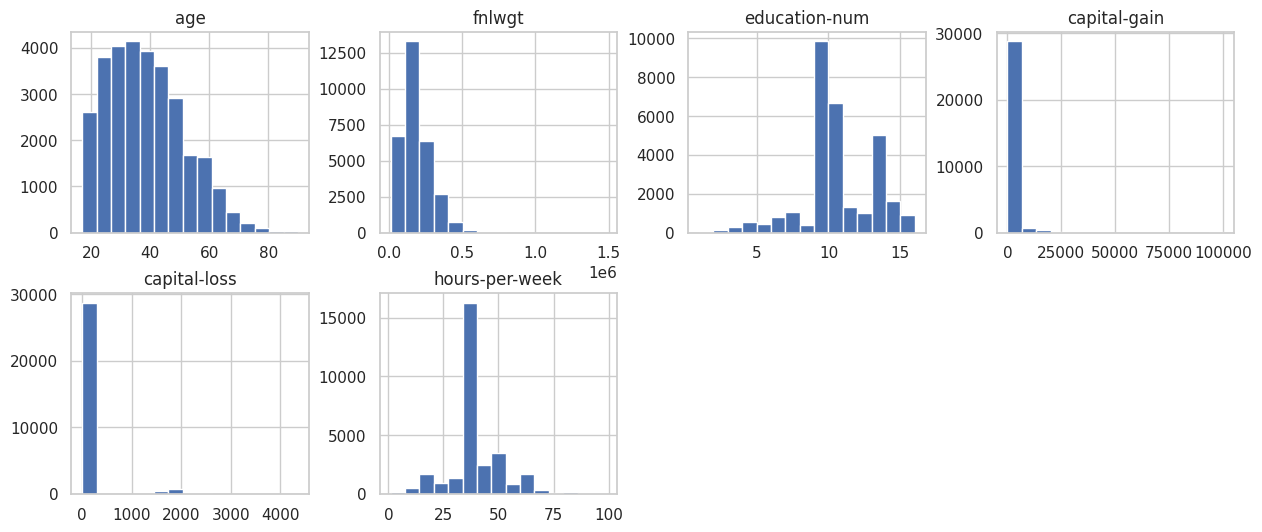

Count plots for categorical features



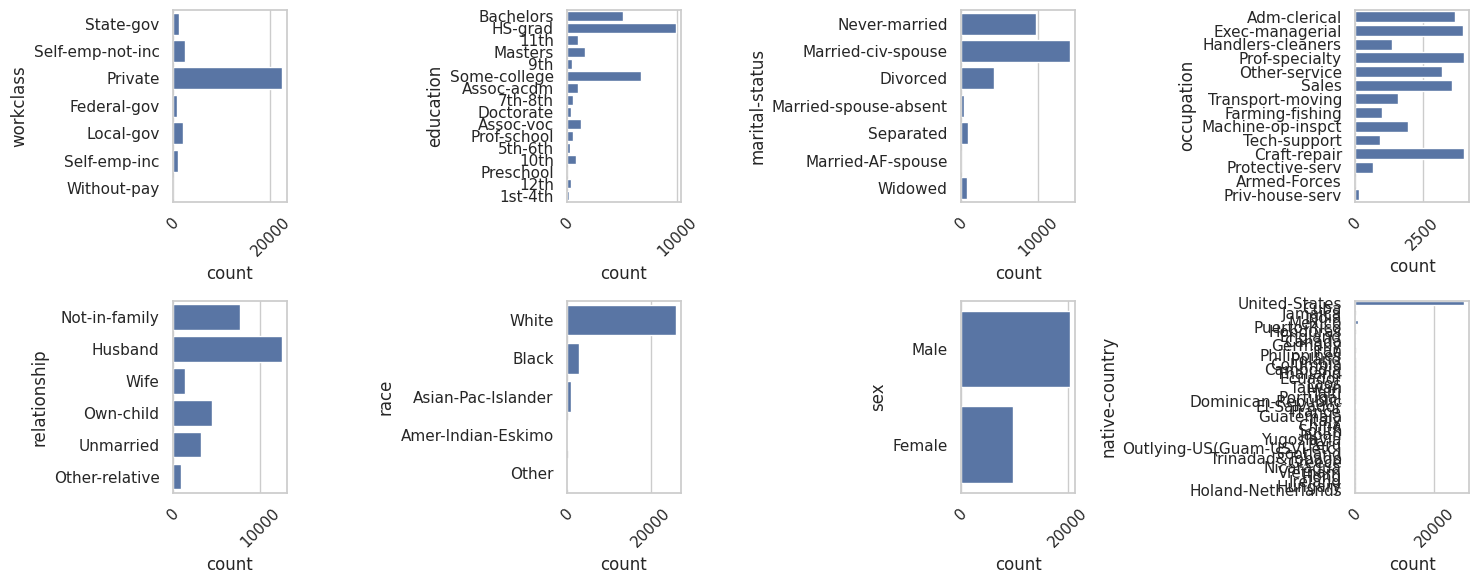

Correlation matrix



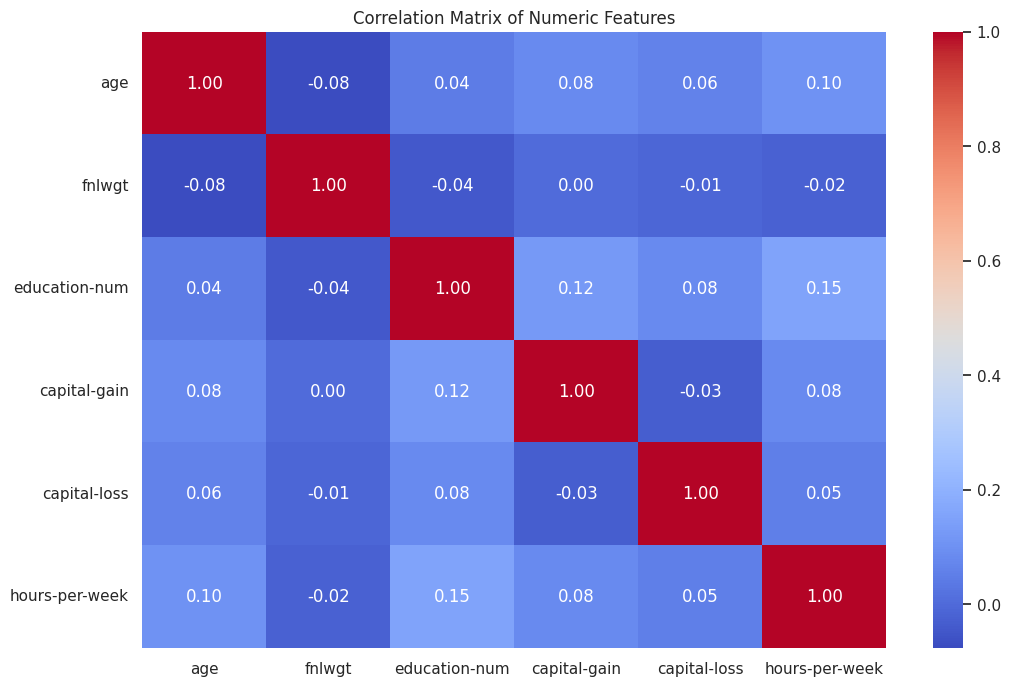

Class imbalance visualization



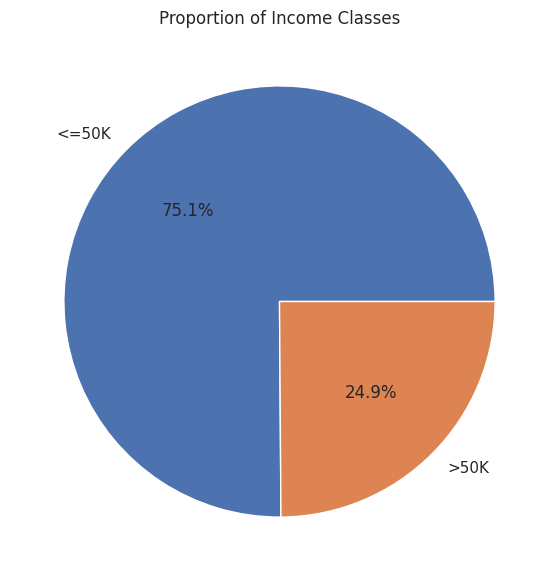

In [ ]:
#ESPLORATORY DATA ANALYSIS
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for better visibility
sns.set(style="whitegrid")

# Histograms for continuous features
print('Histograms for continuous features\n')
data[continuous_features].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.show()


# Count plots for categorical features
print('Count plots for categorical features\n')
fig, ax = plt.subplots(2, 4, figsize=(15, 6))  # Adjust shape according to number of categorical features
for var, subplot in zip(categorical_features[:-1], ax.flatten()):
    sns.countplot(data[var], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

# Exclude non-numeric columns and compute the correlation matrix
numeric_data = data.select_dtypes(include=[np.number])  # This only includes numeric columns
corr_matrix = numeric_data.corr()

# Plot the correlation matrix
print('Correlation matrix\n')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Pie chart for proportion of classes
print('Class imbalance visualization\n')
plt.figure(figsize=(7, 7))
data['income'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Income Classes')
plt.ylabel('')
plt.show()

#Data Preprocessing
After we have explored the dataset, we can prepare it for the training.
In this section, we split the data into training, validation, and test sets to ensure proper evaluation and validation of our models during training. We elso do one-hot encoding of categorical variables and we scale the numerical variables.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd

# Step 1: One-hot encode categorical variables
data_cat = pd.get_dummies(data, columns=categorical_features)

# Step 2: Convert boolean columns to integers (optional, but safe)
for col in data_cat.columns:
    if data_cat[col].dtype == bool:
        data_cat[col] = data_cat[col].astype(int)

# Step 3: Split features and labels
features = data_cat.drop(['income_<=50K', 'income_>50K'], axis=1)
labels = data_cat['income_>50K'].values  # convert to array

# Step 4: Split before scaling
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Step 5: Fit scaler only on training set (only on continuous features)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_val_scaled[continuous_features] = scaler.transform(X_val[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])

# Step 6: Convert to torch tensors
def to_tensor(X_df, y_array):
    X_tensor = torch.tensor(X_df.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_array, dtype=torch.float32)
    return X_tensor, y_tensor

X_train_tensor, y_train_tensor = to_tensor(X_train_scaled, y_train)
X_val_tensor, y_val_tensor = to_tensor(X_val_scaled, y_val)
X_test_tensor, y_test_tensor = to_tensor(X_test_scaled, y_test)


It is important to always have a baseline for our deep learning models. Here we will compare the performances of the MLP against traditional machine learning models: Logistic Regression and Random Forest. We first convert our tensors back to numpy arrays, which are required by Scikit-learn's. After training each model on the training set, we evaluate them on the validation set to assess their accuracy and overall classification performance, including F1 scores. Play with the model parameters to get the best performances on the validation set!


In [ ]:
#BENCHMARKS

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,  f1_score, precision_recall_curve, confusion_matrix


X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_test_np = X_test_tensor.numpy()
y_test_np = y_test_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

# Train Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_np, y_train_np)

# Train Random Forest
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=25)
random_forest_model.fit(X_train_np, y_train_np)

# Function to evaluate the classifier and find the best threshold for F1 score
def evaluate_classifier_for_best_threshold(classifier, X, y_true, y_scores=None, threshold=0):
    # Get the probability scores for the positive class
    if y_scores == None:
      y_scores = classifier.predict_proba(X)[:, 1]

    # Calculate precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2 * recall * precision / (recall + precision)
    # Find the index of the highest F1 score
    best_f1_index = np.argmax(f1_scores)
    if threshold == 0:
      best_threshold = thresholds[best_f1_index]
    else:
      best_threshold = threshold
    best_f1_score = f1_scores[best_f1_index]

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1 Score: {best_f1_score:.4f}")
    # Calculate accuracy and classification report using the best threshold
    y_pred = [1 if score >= best_threshold else 0 for score in y_scores]
    print(f"Accuracy:", accuracy_score(y_true, y_pred))
    print(f"Classification Report:\n", classification_report(y_true, y_pred, target_names=['<=50K', '>50K']))
    print(f"Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    return best_threshold, best_f1_score

# Evaluate the Logistic Regression classifier and find the best threshold
logistic_best_threshold, logreg_best_f1_score = evaluate_classifier_for_best_threshold(logistic_model, X_val_np, y_val_np)

# Evaluate the Random Forest classifier and find the best threshold
rf_best_threshold, rf_best_f1_score = evaluate_classifier_for_best_threshold(random_forest_model, X_val_np, y_val_np)



Best Threshold: 0.3767
Best F1 Score: 0.6985
Accuracy: 0.8431957566716393
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.88      0.89      4529
        >50K       0.67      0.73      0.70      1504

    accuracy                           0.84      6033
   macro avg       0.79      0.80      0.80      6033
weighted avg       0.85      0.84      0.85      6033

Confusion Matrix:
 [[3991  538]
 [ 408 1096]]
Best Threshold: 0.3909
Best F1 Score: 0.7183
Accuracy: 0.8539698325874358
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.89      0.90      4529
        >50K       0.69      0.75      0.72      1504

    accuracy                           0.85      6033
   macro avg       0.80      0.82      0.81      6033
weighted avg       0.86      0.85      0.86      6033

Confusion Matrix:
 [[4029  500]
 [ 381 1123]]


#Neural Network Definition
Here we define a Multilayer Perceptron (MLP) model using PyTorch. The MLP is a class of feedforward artificial neural network that consists of at least four layers of nodes: an input layer, two hidden layer, and an output layer. Each node, except for the input nodes, uses a nonlinear activation function. We'll use this model to classify individuals based on their income level. Try to modify the architecture, add more layers, change the activations, vary the number of neurons in each layer.


In [ ]:
#MODEL ARCHITECTURE DEFINITION AND INITIALIZATION
from torchsummary import summary

# Define MLP for classification
class MLP_Classifier(nn.Module):
    def __init__(self):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = MLP_Classifier().to(device)

#summary of model structure
summary(model, input_size=(X_train_tensor.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 18096, 64]           6,720
              ReLU-2            [-1, 18096, 64]               0
            Linear-3             [-1, 18096, 8]             520
              ReLU-4             [-1, 18096, 8]               0
            Linear-5             [-1, 18096, 1]               9
           Sigmoid-6             [-1, 18096, 1]               0
Total params: 7,249
Trainable params: 7,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 7.18
Forward/backward pass size (MB): 20.16
Params size (MB): 0.03
Estimated Total Size (MB): 27.36
----------------------------------------------------------------


#Neural Network Training
In this block, we handle the training process of our MLP model. Training is conducted over multiple epochs, where the model learns to predict the training data's outcomes accurately. We also utilize a validation set to monitor the model's performance.

Epoch: 1, Training Loss: 0.5490, Validation Loss: 0.3946
Epoch: 2, Training Loss: 0.3691, Validation Loss: 0.3620
Epoch: 3, Training Loss: 0.3433, Validation Loss: 0.3379
Epoch: 4, Training Loss: 0.3270, Validation Loss: 0.3272
Epoch: 5, Training Loss: 0.3211, Validation Loss: 0.3225
Epoch: 6, Training Loss: 0.3173, Validation Loss: 0.3190
Epoch: 7, Training Loss: 0.3142, Validation Loss: 0.3184
Epoch: 8, Training Loss: 0.3117, Validation Loss: 0.3160
Epoch: 9, Training Loss: 0.3100, Validation Loss: 0.3199
Epoch: 10, Training Loss: 0.3090, Validation Loss: 0.3161
Epoch: 11, Training Loss: 0.3078, Validation Loss: 0.3160
Epoch: 12, Training Loss: 0.3068, Validation Loss: 0.3162
Epoch: 13, Training Loss: 0.3052, Validation Loss: 0.3154
Epoch: 14, Training Loss: 0.3053, Validation Loss: 0.3160
Epoch: 15, Training Loss: 0.3039, Validation Loss: 0.3154
Epoch: 16, Training Loss: 0.3030, Validation Loss: 0.3156
Epoch: 17, Training Loss: 0.3021, Validation Loss: 0.3177
Epoch: 18, Training Los

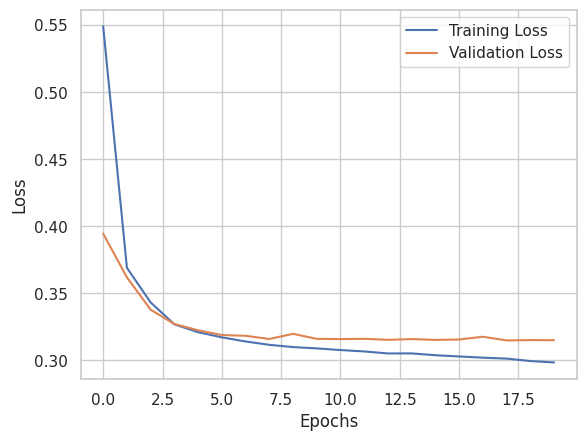

In [ ]:
#MODEL TRAINING

#hyperparameter
lr = 0.0005
batch_size = 128

#training parameters
epochs = 20

#training model function
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target.view(-1, 1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

    return train_losses, val_losses

# Create TensorDatasets and DataLoaders for Training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Loss Function
#Uncomment to handle class imbalance in the Loss
#class_counts = data_cat['income_>50K'].value_counts().sort_index().values
#class_weights = [sum(class_counts) / c for c in class_counts]
#class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
#criterion = nn.BCELoss(weight=class_weights_tensor[0])
criterion = nn.BCELoss()

# Instantiate optimizer and early stopper
optimizer = optim.Adam(model.parameters(), lr=lr)


# Run training and plot losses
train_losses, val_losses = train_model(epochs, model, optimizer, criterion, train_loader, test_loader)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Evaluation
Post-training, we evaluate the MLP model using the validation set to check its generalization capability. We compute various performance metrics like accuracy and F1 score, and visualize the results using a confusion matrix. This helps in understanding how well the model is performing and where it might be making errors. Go back and play with the model architecture and with the hyperparameters to find the best performing neural network.

In [ ]:
#EVALUATE MODEL ON VALIDATION SET

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve

# Function to evaluate the model and find the best threshold for F1 score
def evaluate_model(data_loader, model=model, threshold=0):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_scores = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_scores.extend(output.view(-1).cpu().numpy())  # Store raw model outputs
            y_true.extend(target.cpu().numpy())


    # Calculate precision-recall pairs for different probability thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2 * recall * precision / (recall + precision)
    # Find the index of the highest F1 score
    best_f1_index = np.argmax(f1_scores)
    if threshold == 0:
      best_threshold = thresholds[best_f1_index]
    else:
      best_threshold = threshold
    best_f1_score = f1_scores[best_f1_index]

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1 Score: {best_f1_score:.4f}")
    # Calculate accuracy and classification report using the best threshold
    y_pred = [1 if score >= best_threshold else 0 for score in y_scores]
    print("Multilayer Perceptron Accuracy:", accuracy_score(y_true, y_pred))
    print("Multilayer Perceptron Classification Report:\n", classification_report(y_true, y_pred, target_names=['<=50K', '>50K']))
    print("Multilayer Perceptron Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    return best_threshold, best_f1_score

# Call the function to evaluate the model and find the best threshold
mlp_best_threshold, mlp_best_f1_score = evaluate_model(val_loader)

Best Threshold: 0.3827
Best F1 Score: 0.7086
Multilayer Perceptron Accuracy: 0.8433615116857285
Multilayer Perceptron Classification Report:
               precision    recall  f1-score   support

       <=50K       0.92      0.87      0.89      4529
        >50K       0.66      0.76      0.71      1504

    accuracy                           0.84      6033
   macro avg       0.79      0.82      0.80      6033
weighted avg       0.85      0.84      0.85      6033

Multilayer Perceptron Confusion Matrix:
 [[3939  590]
 [ 355 1149]]


Finally, we compare the performance of our best MLP model against traditional machine learning models such as Logistic Regression and Random Forest. This comparison is crucial to evaluate the effectiveness of deep learning models against conventional approaches on this specific dataset. Use the test set only after having spent some time tuning the hyperparameters (also of the standard ML models) and the neural network architecture. **Once you test your models on the test set, you can't go back and modify them!**

In [ ]:
#COMPARE ALL MODELS ON TEST SET

# Predictions and Evaluations Logistic Model
print("--------------------------\nLOGISTIC MODEL\n--------------------------\n")
logistic_best_threshold, logistic_best_f1_score = evaluate_classifier_for_best_threshold(logistic_model,
                                                                                         X_test_np,
                                                                                         y_test_np,
                                                                                         threshold=logistic_best_threshold)

# Predictions and Evaluations Random Forest
print("\n--------------------------\nRANDOM FOREST\n--------------------------\n")
rf_best_threshold, rf_best_f1_score = evaluate_classifier_for_best_threshold(random_forest_model,
                                                                             X_test_np,
                                                                             y_test_np,
                                                                             threshold=rf_best_threshold)


# Predictions and Evaluations Multilayer Perceptron
print("\n--------------------------\nMULTILAYER PERCEPTRON\n--------------------------\n")
mlp_best_threshold, mlp_best_f1_score = evaluate_model(test_loader, threshold=mlp_best_threshold)



--------------------------
LOGISTIC MODEL
--------------------------

Best Threshold: 0.3767
Best F1 Score: 0.7007
Accuracy: 0.8397149013757667
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.90      0.88      0.89      4503
        >50K       0.67      0.72      0.69      1530

    accuracy                           0.84      6033
   macro avg       0.79      0.80      0.79      6033
weighted avg       0.84      0.84      0.84      6033

Confusion Matrix:
 [[3967  536]
 [ 431 1099]]

--------------------------
RANDOM FOREST
--------------------------

Best Threshold: 0.3909
Best F1 Score: 0.7239
Accuracy: 0.8528095474888115
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.89      0.90      4503
        >50K       0.69      0.75      0.72      1530

    accuracy                           0.85      6033
   macro avg       0.80      0.82      0.81      6033
weighted avg       

# BONUS: Model Ensembling

Leveraging the strengths of different models can lead to improved overall performance, especially for complex tasks. Each model may capture different patterns or relationships within the data, and by combining them, we can often achieve a more robust and accurate predictive system.

In this section, we implement a strategy to merge the predictions from our trained Multilayer Perceptron (MLP) and Random Forest classifier. The key to this approach is to utilize the confidence of each model's predictions. For each data point, we compare the predicted probabilities (the model's certainty of its prediction) from both the MLP and the Random Forest. We then select the prediction from the model that exhibits higher confidence in its decision.


In [ ]:
#BONUS: MODEL ENSEMBLING

def combined_predictions(mlp_model, rf_model, X_mlp, X_rf):
    # Set MLP model to eval mode
    mlp_model.eval()

    # Get the device of the model
    device = next(mlp_model.parameters()).device

    # Move input to the same device as the model
    X_mlp = X_mlp.to(device)

    # Get predictions for MLP
    with torch.no_grad():
        mlp_probs = torch.sigmoid(mlp_model(X_mlp)).cpu().numpy()

    # Get probabilities for Random Forest (still on CPU)
    rf_probs = rf_model.predict_proba(X_rf)[:, 1]

    # Combine predictions
    combined_probs = []
    for i in range(len(X_rf)):
        if max(rf_probs[i], 1 - rf_probs[i]) > max(mlp_probs[i][0], 1 - mlp_probs[i][0]):
            combined_probs.append(rf_probs[i])
        else:
            combined_probs.append(mlp_probs[i][0])

    return combined_probs


# First run the combined predictions function on validation
combined_probs = combined_predictions(model, random_forest_model, X_val_tensor, X_val_np)

# Get best threshold on validation set
combined_best_threshold, combined_best_f1_score = evaluate_classifier_for_best_threshold(random_forest_model,
                                                                                         X_val_np,
                                                                                         y_val_np,
                                                                                         y_scores=combined_probs)

# Run the combined predictions function on test
combined_probs = combined_predictions(model, random_forest_model, X_test_tensor, X_test_np)

print("--------------------------\nCOMBINED MODEL\n--------------------------\n")

# Evaluate combined predictions on test set
combined_best_threshold, combined_best_f1_score = evaluate_classifier_for_best_threshold(model,
                                                                                         X_test_np,
                                                                                         y_test_np,
                                                                                         y_scores=combined_probs,
                                                                                         threshold=combined_best_threshold)



Best Threshold: 0.3911
Best F1 Score: 0.7159
Accuracy: 0.8508204873197415
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.92      0.88      0.90      4529
        >50K       0.68      0.75      0.72      1504

    accuracy                           0.85      6033
   macro avg       0.80      0.82      0.81      6033
weighted avg       0.86      0.85      0.85      6033

Confusion Matrix:
 [[3999  530]
 [ 370 1134]]
--------------------------
COMBINED MODEL
--------------------------

Best Threshold: 0.3911
Best F1 Score: 0.7227
Accuracy: 0.8511519973479198
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.91      0.88      0.90      4503
        >50K       0.69      0.75      0.72      1530

    accuracy                           0.85      6033
   macro avg       0.80      0.82      0.81      6033
weighted avg       0.86      0.85      0.85      6033

Confusion Matrix:
 [[3980  523]
 [



## Exercises
1. Experiment with different network architectures:
   - Try different numbers of hidden layers (1, 3, or more)
   - Vary the number of neurons in each hidden layer
   - Compare the training curves and final performance

2. Explore different activation functions:
   - Replace ReLU with alternatives like Sigmoid, Tanh, or Leaky ReLU
   - Document the impact on training speed and final model performance

3. Experiment with optimization parameters:
   - Try different learning rates (0.1, 0.01, 0.0001)
   - Compare different optimizers (SGD, Adam, RMSprop)
   - Implement and observe the effect of batch size changes

4. Analyze overfitting:
   - Train the model for a different number of epochs and observe the validation curve
   - Identify when overfitting begins to occur
   
5. Experiment with the scaler:
   - Are the machine learning algorithms affected when the input features are not properly scaled?
   - What about the MLP?